In [2]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from scipy.stats import t, normaltest, bartlett, levene

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [3]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

식물의 성장이 햇빛 노출과 관수 빈도에 의해 영향을 받는지 여부를 알고 싶어한다.
실험은 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록하였다.

In [4]:
origin = load_data('sunlight_watering_growth')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/sunlight_watering_growth.xlsx
[desc] 식물의 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록한 데이터 (출처: 방송통신대학교 통계학개론)

field    description
-------  ----------------------------------------------------------------
water    각 식물에 물을 주는 빈도 (매일:`daily`, 매주: `weekly`)
sun      각 식물이 받은 햇빛 노출량 (낮음:`low`, 중간:`med`, 높음:`high`)
height   2개월 후 각 식물의 높이 (인치)


===== 데이터 크기 확인 =====
데이터셋 크기: (120, 3)
열 개수: 3
행 개수: 120

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   water   120 non-null    object 
 1   sun     120 non-null    object 
 2   height  120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB
None


,water,sun,height
0,daily,low,4.9
1,daily,low,7.9
2,daily,low,3.9
3,daily,low,5.1
4,daily,low,5.2


관수빈도별 햇빛 노출 빈도에 따른 식물 높이 비교

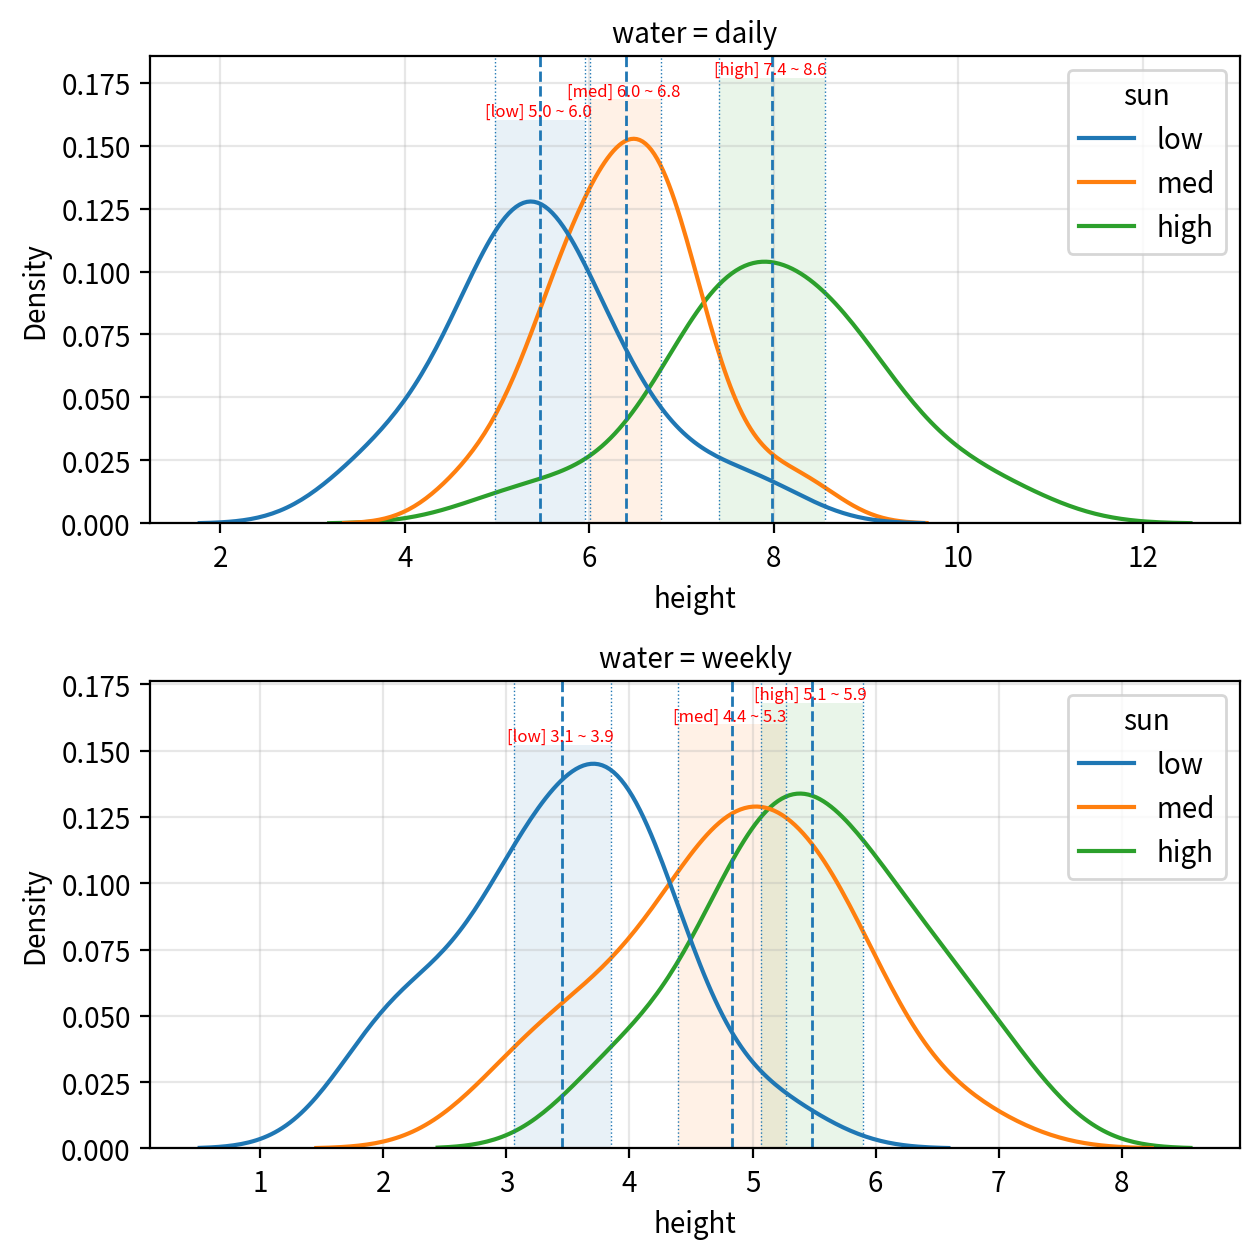

In [5]:
field = 'height'
group_field = 'water'
hue_field = 'sun'

# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows

figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for i,v in enumerate(group_values):
    temp = data[data[group_field]== v]

    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        max= temp_sub[field].max()
        clevel = 0.95
        dof = len(temp_sub[field]) - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
         s="[%s] %0.1f ~ %0.1f " % (h, cmin, cmax), horizontalalignment="center",
        verticalalignment="bottom",fontdict={"size":6, "color":"red"})



plt.tight_layout()
plt.show()
plt.close()





햇빛 노출 빈도별 관수량에 따른 식물 높이 비교

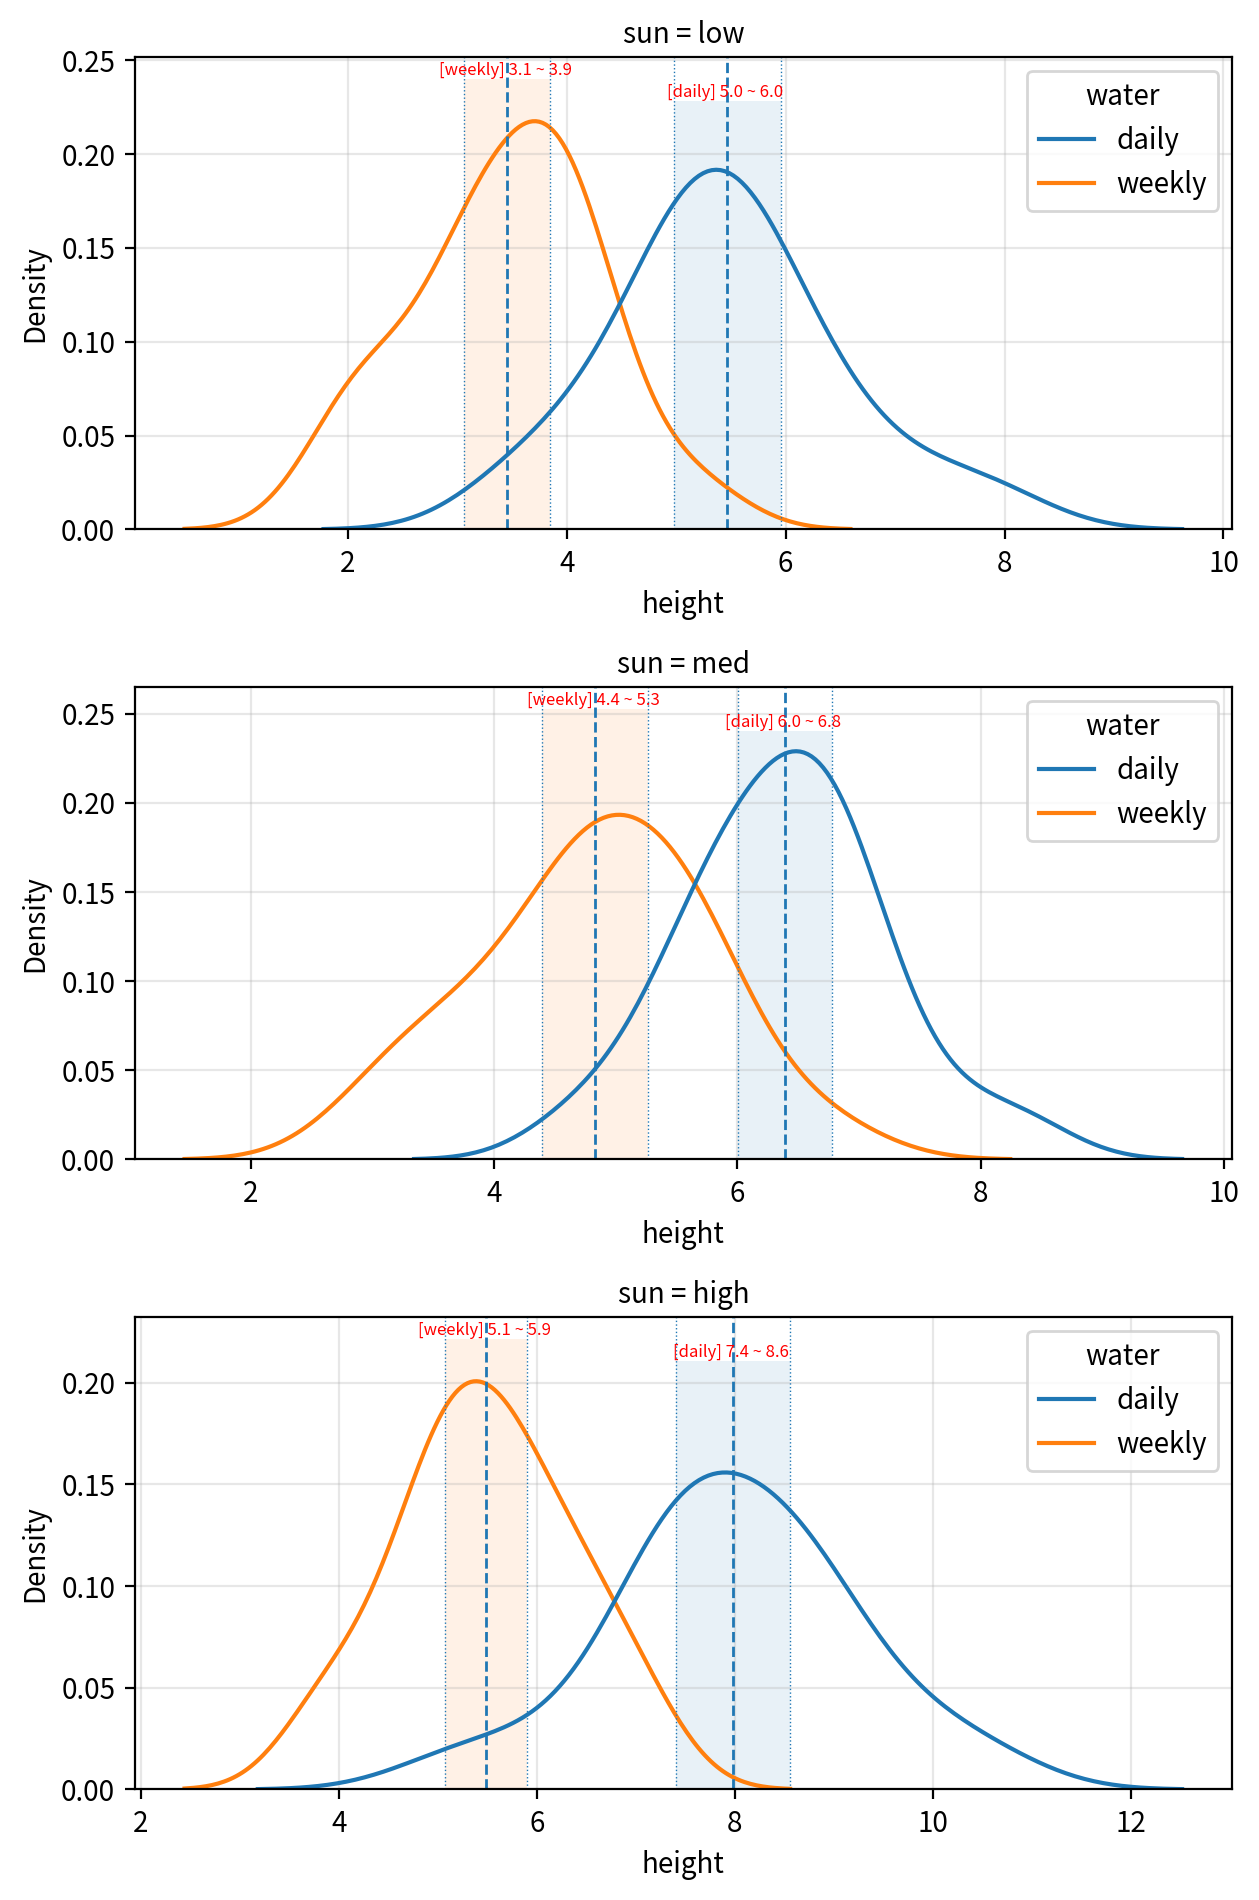

In [6]:
field = 'height'
group_field = 'sun'
hue_field = 'water'

# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows

figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for i,v in enumerate(group_values):
    temp = data[data[group_field]== v]

    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        max = temp_sub[field].max()
        clevel = 0.95
        dof = len(temp_sub[field]) - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
         s="[%s] %0.1f ~ %0.1f " % (h, cmin, cmax), horizontalalignment="center",
        verticalalignment="bottom",fontdict={"size":6, "color":"red"})



plt.tight_layout()
plt.show()
plt.close()





분산분석의 가정확인

In [7]:
data = origin.copy()
xname = ['water', 'sun']
yname = 'height'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p>0.05
        report.append({
            "field":  "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize


if normal_dist:
    n = "Bartlett"

    s,p = bartlett(*equal_var_fields)

else:
    n = "Levene"

    s,p = levene(*equal_var_fields)

equal_var = p>0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
    })

report_df =DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"daily, low",1.461514,0.481544,True
"daily, med",0.866582,0.648372,True
"daily, high",0.801917,0.669678,True
"weekly, low",0.073958,0.963697,True
"weekly, med",0.160764,0.922764,True
"weekly, high",0.052520,0.974082,True
Bartlett,4.488400,0.481437,True


In [8]:
xname =['water', 'sun']
yname = 'height'

pg_anova = anova(data = origin, dv=yname, between=xname)
pg_anova

,Source,SS,DF,MS,F,p-unc,np2
0,water,122.816333,1,122.816333,130.528994,1.301312e-20,0.533798
1,sun,103.292167,2,51.646083,54.889371,2.013276e-17,0.490568
2,water * sun,4.327167,2,2.163583,2.299453,1.049489e-01,0.038777
3,Residual,107.264000,114,0.940912,NaN,NaN,NaN


In [9]:
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val<=0.05:
        print(f"-> {source} 효과는 유의함. (대립가설 채택: p<=0.05)")

    else:
        print(f"-> {source}효과는 유의하지 않음. (귀무가설 채택: p>0.05)")

-> water 효과는 유의함. (대립가설 채택: p<=0.05)
-> sun 효과는 유의함. (대립가설 채택: p<=0.05)
-> water * sun효과는 유의하지 않음. (귀무가설 채택: p>0.05)
-> Residual효과는 유의하지 않음. (귀무가설 채택: p>0.05)


In [11]:
xname = ['water', 'sun']
yname = 'height'
data = origin[xname + [yname]]

levels = {}

for factor in xname:
    level_count = data[factor].nunique()
    levels[factor] = level_count

pvals = {}

for index, row in pg_anova.iterrows():      #행을 하나씩 꺼냄!!
    source_name = row['Source']
    p_value = row['p-unc']
    pvals[source_name] = p_value

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor]<=2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) ->사후검정 수행 안함")
        continue
    print(f"- 주효과 유의 (p={p_val:.3g}) ->사후검정 수행")

    if equal_var:
        print("  Tukey HSD 사용(등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)

    else:
        print("     Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
        display(hoc_df)

interaction_names = [src for src in pvals.keys() if'*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val<=0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g})-> 단순주효과 분석필요")
    else:
        print(f"- 상호작용 유의하지 (p={p_val:.3g})-> 단순주효과 분석필요없음")


[water]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[sun]
- 주효과 유의 (p=2.01e-17) ->사후검정 수행
  Tukey HSD 사용(등분산 충족)

[water * sun] 상호작용 효과
- 상호작용 유의하지 (p=0.105)-> 단순주효과 분석필요없음


1.분석 목적
본 분석은 식물의 높이에 대해 관수 빈도와 햇빛 노출이 어떤 영향을 미치는지 평가하기 위해 이원분산분석을 수행하였다.

2. 분산분석주요 결과

water: F = 130.53, p = 1.30e-20, ηp² = 0.534 → 유의함(대립가설 채택)
sun: F = 54.89, p = 2.01e-17, ηp² = 0.491 → 유의함(대립가설 채택)
water × sun: F = 2.30, p = 0.105, ηp² = 0.039 → 유의하지 않음(귀무가설 채
택)
<물주기와 햇빛은 식물 높이에 모두 유의한 영향을 주지만, 두 요인이 결합해 특별한 상호작용 효과를 만들어내지는 않는다.>

3. 기술통계 및 집단별 평균 

 
water 수준별 평균
daily: 6.63
weekly: 4.57
→ 매일 물 준 그룹이 크게 성장함.


sun 수준별 평균
low: 4.44
med: 5.61
high: 6.73
→ 햇빛이 많을수록 뚜렷한 증가.

상호작용 조합 평균 | water | low | med | high | |——–|——|——|——| | daily |
5.40 | 6.41 | 7.88 | | weekly | 3.46 | 4.67 | 5.52 |
두 요인의 증가 방향은 거의 평행한 형태로 나타나 상호작용이 약하다는 점을 뒷받침한다.


4. 사후검정 결과

water: 2수준 요인이므로 사후검정 불필요.
sun: 3수준 + 주효과 유의 → Tukey HSD 수행

결과: 
high > low (차이 2.27, p < .001)
high > med (차이 1.12, p < .01)
med > low (차이 1.15, p < .01)

상호작용: p=0.105 → 단순주효과 분석 불필요
햇빛의 세 조건(low, med, high)은 서로 모두 유의하게 다른 평균을 가진다.

5.최종 결론 요약:
관수(water)는 식물의 성장에 강력한 영향을 줌(매일 물을 줄수록 더 큼).
햇빛(sun)은 명확한 선형적 효과를 가지며, high > med > low 순으로 성장 증가.
두 요인이 결합해 상승효과를 만드는 상호작용은 없음.
사후검정 결과, 햇빛 조건 세 그룹은 모두 서로 유의하게 차이가 있음.

식물의 높이는 관수 빈도와 햇빛 수준의 영향을 크게 받으며, 두 요인은 독립적으로 작용하여 성
장 패턴을 결정한다.